In [1]:
### Base settings
import pandas as pd
import numpy as np
import plotly.express as px
#Optional, but suppresses the copy warnings...
pd.options.mode.chained_assignment = None

In [2]:
### data import
path = "taxiData.csv"
df=pd.read_csv(path)
path = "locationDictionary.csv"
df2 = pd.read_csv(path)
locationDict = df2.set_index('Text').T.to_dict('list') #building dictionary to map text into useful building numbers
df['Stop'] = df['from'].map(locationDict) #populating limited number of taxi stop info
#df['Stop'] = df.Stop.astype(int)
df = df.dropna()
df["Stop"] = df["Stop"].str[0] #extracting the first element of each so it's just a number instead of a list
df["Date"] = pd.to_datetime(df.date + " " + df.time)


#this block counts info up, then plots the pickup data
path = "locationSheet.csv"
df2=pd.read_csv(path)
puList = df.Stop.unique()
puDict = dict()
for building in puList:
    tempDF = df[df.Stop==building]
    #print("For stop ",building," we have ",len(tempDF.index)," entries")
    if len(tempDF.index)!=0:
        puDict[building] = len(tempDF.index)

#this is because stop 2A keeps causing me to have errors
df2=df2[df2.building!="2A"]
df2['building'] = df2.building.astype(int)
df2['taxiCount'] = df2.building.map(puDict)
df2=df2.fillna(0)

/tmp/ipykernel_11022/3522688680.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df.date + " " + df.time)


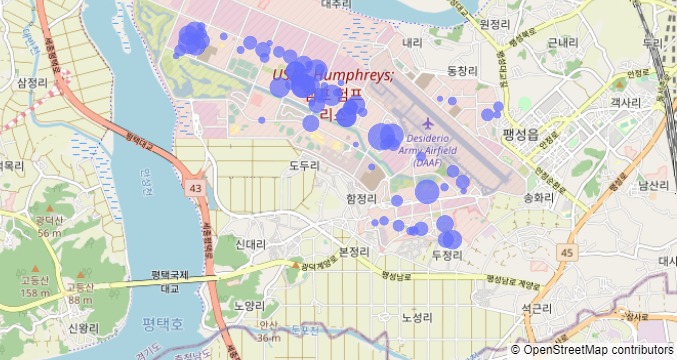

In [3]:
fig = px.scatter_mapbox(df2, lat="lat", lon="long", size="taxiCount", 
                        hover_name="notes", 
                        center=dict(lat=36.96348,lon=127.0171))
fig.update_layout(mapbox_style="open-street-map") #loads background map
fig.update_layout(height=500,margin={"r":0,"t":0,"l":0,"b":0}) #makes map bigger and fills space
fig.show()

In [4]:
df["Category"]="filler"
am=[5,6,7,8,9,10,11]
pm=[12,13,14,15,16,17,18,19]
night=[20,21,22,23,24,0,1,2,3,4]
def where(row):
    time = row['Date'].hour
    if time in am:
        return "am"
    if time in pm:
        return "pm"
    if time in night:
        return "night"
df.Category = df.apply (lambda row:where(row),axis=1)
df["Hour"]="filler"
def where2(row):
    return row['Date'].hour
df.Hour = df.apply (lambda row:where2(row),axis=1)
df2['Hour']=-1

df3 = pd.DataFrame(columns=df2.columns)
puList = df2.building.unique()
for stop in puList:
    for num in range(24):
        tempDF=pd.DataFrame(df[(df['Hour']==num) & (df['Stop']==stop)])
        thisRow=df2[df2.building==stop]
        thisRow['Hour']=num
        thisRow['taxiCount']=len(tempDF)
        df3=pd.concat([df3,thisRow])

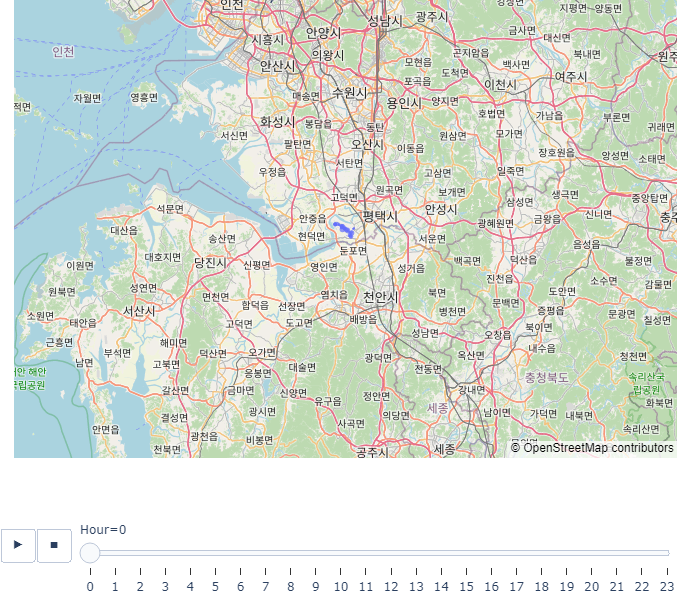

In [5]:
df3.taxiCount = df3.taxiCount.astype('int32')
fig = px.scatter_mapbox(df3, lat="lat", lon="long", size="taxiCount", 
                        hover_name="notes", animation_frame="Hour",
                        center=dict(lat=36.96348,lon=127.0171),
                       title="Plot of Taxi Demand Data by Hour")
fig.update_layout(mapbox_style="open-street-map") #loads background map
fig.update_layout(height=600,margin={"r":0,"t":0,"l":0,"b":0}) #makes map bigger and fills space
fig.show()